# 1 Training Dataset

In [1]:
# --- STEP A: Generate Ntrain samples (fields, mask, polygons) ---

import numpy as np, json, csv
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath

# ---------- Grid + synthetic fields ----------
def make_grid(nx=300, ny=200):
    lon = np.linspace(-15, 30, nx)
    lat = np.linspace(35, 60, ny)
    lon2d, lat2d = np.meshgrid(lon, lat)
    return lon2d, lat2d, lon, lat

def gaussian_blob(lon2d, lat2d, lon0, lat0, amp, sx, sy):
    return amp * np.exp(-(((lon2d - lon0)/sx)**2 + ((lat2d - lat0)/sy)**2))

def random_fields(lon2d, lat2d, seed=0):
    rng = np.random.default_rng(seed)
    wind = 8 + 0.1*(lon2d - lon2d.mean()) + 0.05*(lat2d - lat2d.mean())
    gust = 10 + 0.05*(lon2d - lon2d.mean()) + 0.08*(lat2d - lat2d.mean())
    for _ in range(rng.integers(3, 6)):
        lon0, lat0 = rng.uniform(-10, 25), rng.uniform(38, 57)
        amp = rng.uniform(10, 18)
        wind += gaussian_blob(lon2d, lat2d, lon0, lat0, amp, 3, 2)
        gust += gaussian_blob(lon2d, lat2d, lon0+0.5, lat0, amp*1.2, 2.5, 1.8)
    return wind, gust

def build_mask(wind, gust, thr_w=18, thr_g=22):
    return ((wind >= thr_w) & (gust >= thr_g)).astype(np.uint8)

# ---------- Connected components (one polygon per blob) ----------
def label_connected_4(mask01: np.ndarray):
    mask01 = (mask01 > 0).astype(np.uint8)
    H, W = mask01.shape
    labels = np.zeros_like(mask01, dtype=np.int32)
    next_label = 1
    for y in range(H):
        for x in range(W):
            if mask01[y, x] == 1 and labels[y, x] == 0:
                stack = [(y, x)]
                labels[y, x] = next_label
                while stack:
                    cy, cx = stack.pop()
                    for ny, nx in ((cy-1, cx), (cy+1, cx), (cy, cx-1), (cy, cx+1)):
                        if 0 <= ny < H and 0 <= nx < W and mask01[ny, nx] == 1 and labels[ny, nx] == 0:
                            labels[ny, nx] = next_label
                            stack.append((ny, nx))
                next_label += 1
    return labels, (next_label - 1)

def iter_paths_from_contourset(cs):
    if hasattr(cs, "collections"):
        for coll in cs.collections:
            if hasattr(coll, "get_paths"):
                for p in coll.get_paths():
                    yield p
    if hasattr(cs, "get_paths"):
        for p in cs.get_paths():
            yield p

def component_to_polygon(comp_mask, lon2d, lat2d, level=0.5, min_vertices=6):
    fig, ax = plt.subplots()
    cs = ax.contour(lon2d, lat2d, comp_mask.astype(float), levels=[level])
    best = None; best_len = -1
    for p in iter_paths_from_contourset(cs):
        v = p.vertices
        if v.shape[0] >= min_vertices and v.shape[0] > best_len:
            best = v; best_len = v.shape[0]
    plt.close(fig)
    if best is None:
        return None
    if not np.allclose(best[0], best[-1]):
        best = np.vstack([best, best[:1]])
    return [(float(x), float(y)) for x, y in best]

def mask_to_polygons_one_per_blob(mask, lon2d, lat2d):
    labels, ncomp = label_connected_4(mask)
    polygons = []
    for cid in range(1, ncomp+1):
        comp = (labels == cid)
        poly = component_to_polygon(comp, lon2d, lat2d)
        if poly is not None:
            polygons.append(poly)
    return polygons

# ---------- Rasterize polygons (union) ----------
def polygons_to_mask_union(polygons, lon2d, lat2d):
    ny, nx = lon2d.shape
    pts = np.column_stack((lon2d.ravel(), lat2d.ravel()))
    out = np.zeros((ny, nx), dtype=np.uint8)
    for poly in polygons:
        if len(poly) < 3: continue
        path = MplPath(poly, closed=True)
        inside = path.contains_points(pts).reshape(ny, nx)
        out |= inside.astype(np.uint8)
    return out

# ---------- Save polygons as GeoJSON ----------
def save_geojson(polygons, path):
    features = []
    for i, poly in enumerate(polygons):
        # ensure closure
        if poly[0] != poly[-1]:
            poly = poly + [poly[0]]
        features.append({
            "type": "Feature",
            "properties": {"id": i},
            "geometry": {"type": "Polygon", "coordinates": [[ [x, y] for (x, y) in poly ]]}
        })
    obj = {"type": "FeatureCollection", "features": features}
    Path(path).write_text(json.dumps(obj), encoding="utf-8")

# ---------- Main generator ----------
def generate_dataset(Ntrain=10, base_seed=3, outdir="warn_demo/samples"):
    out = Path(outdir); out.mkdir(parents=True, exist_ok=True)
    lon2d, lat2d, lon, lat = make_grid()
    index_rows = []
    for i in range(Ntrain):
        seed = base_seed + i
        wind, gust = random_fields(lon2d, lat2d, seed=seed)
        mask = build_mask(wind, gust)
        polygons = mask_to_polygons_one_per_blob(mask, lon2d, lat2d)
        mask2 = polygons_to_mask_union(polygons, lon2d, lat2d)

        stem = f"sample_{i:04d}"
        npz_path = out / f"{stem}.npz"
        gj_path  = out / f"polygons_{i:04d}.geojson"

        np.savez(npz_path, lon=lon, lat=lat, wind=wind, gust=gust, mask=mask, mask2=mask2,
                 seed=seed, thr_w=18, thr_g=22)
        save_geojson(polygons, gj_path)

        diff = int(np.abs(mask2 - mask).sum())
        index_rows.append([i, seed, npz_path.name, gj_path.name, len(polygons), diff])

    # write simple CSV index
    with (out / "index.csv").open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f); w.writerow(["idx","seed","npz","geojson","n_polygons","diff_pixels"])
        w.writerows(index_rows)

    print(f"Generated {len(index_rows)} samples in {out.resolve()}")
    print("First 3 entries:", index_rows[:3])

# ---- Run generator ----
generate_dataset(Ntrain=10, base_seed=100, outdir="warn_demo/samples")


Generated 10 samples in D:\potthast_d\research\cbcf\warn_demo\samples
First 3 entries: [[0, 100, 'sample_0000.npz', 'polygons_0000.geojson', 4, 0], [1, 101, 'sample_0001.npz', 'polygons_0001.geojson', 1, 0], [2, 102, 'sample_0002.npz', 'polygons_0002.geojson', 3, 0]]


# 2 Visualization

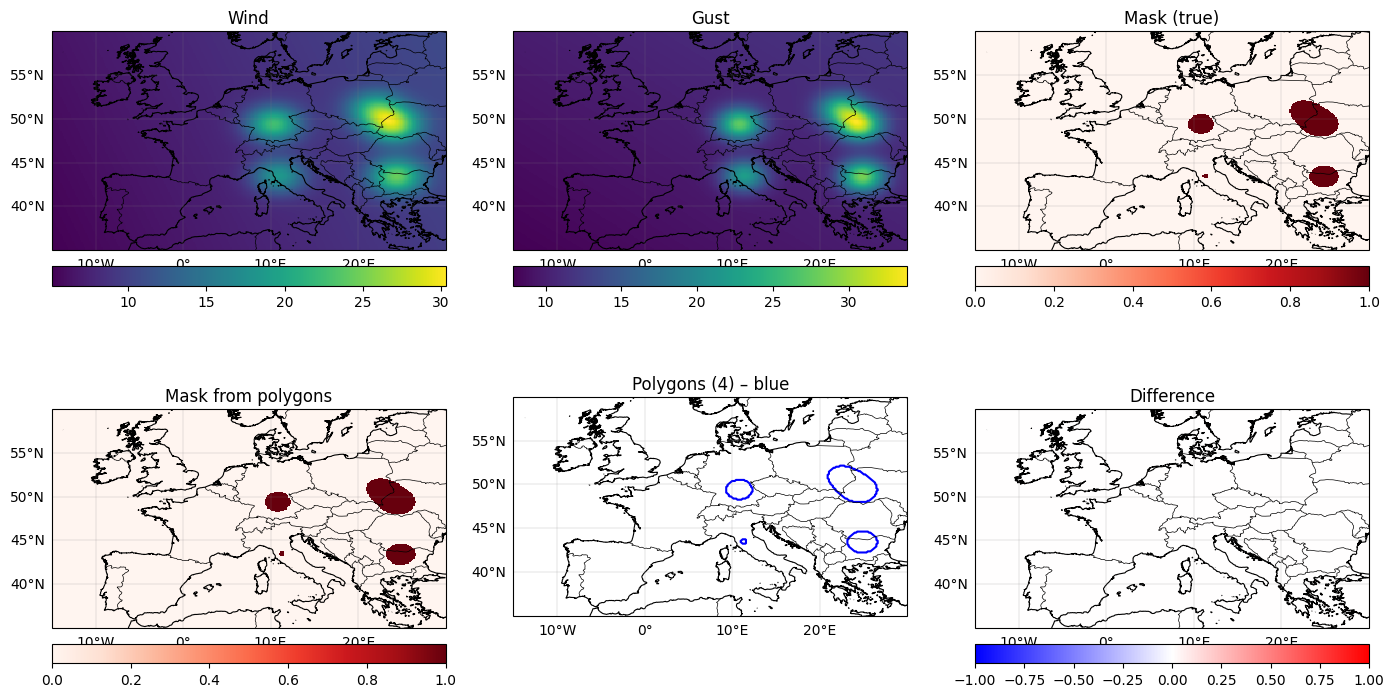

Quick stats:  n_polygons=4,  diff_pixels=0,  mean_abs_diff=0.000000


In [10]:
# --- STEP B: Load & visualize one sample k (map + polygons) ---

import numpy as np
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path

def load_sample(k, outdir="warn_demo/samples"):
    npz = np.load(Path(outdir)/f"sample_{k:04d}.npz")
    with open(Path(outdir)/f"polygons_{k:04d}.geojson","r",encoding="utf-8") as f:
        gj = json.load(f)
    lon, lat = npz["lon"], npz["lat"]
    wind, gust, mask, mask2 = npz["wind"], npz["gust"], npz["mask"], npz["mask2"]
    polygons = []
    for feat in gj.get("features", []):
        coords = feat["geometry"]["coordinates"][0]
        polygons.append([(float(x), float(y)) for x,y in coords])
    return lon, lat, wind, gust, mask, mask2, polygons

def setup_map(ax, extent):
    proj = ccrs.PlateCarree()
    ax.set_extent(extent, crs=proj)
    ax.coastlines("10m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)
    gl.top_labels = gl.right_labels = False

def draw_polygons(ax, polygons, color="blue", linewidth=1.5):
    proj = ccrs.PlateCarree()
    import numpy as np
    from matplotlib.path import Path as MplPath
    from matplotlib.patches import PathPatch
    for poly in polygons:
        verts = np.asarray(poly, float)
        if len(verts) < 3: continue
        # split at large jumps to avoid bridging
        d = np.sqrt(np.sum(np.diff(verts, axis=0)**2, axis=1))
        breaks = np.where(d > 2.0)[0]
        segments = []; start = 0
        for b in breaks:
            segments.append(verts[start:b+1]); start = b+1
        segments.append(verts[start:])
        for seg in segments:
            if len(seg) < 3: continue
            if not np.allclose(seg[0], seg[-1]): seg = np.vstack([seg, seg[:1]])
            n = len(seg)
            codes = np.full(n, MplPath.LINETO, dtype=np.uint8); codes[0] = MplPath.MOVETO; codes[-1] = MplPath.CLOSEPOLY
            path = MplPath(seg, codes)
            ax.add_patch(PathPatch(path, transform=proj, fill=False, edgecolor=color, linewidth=linewidth))

# ---- pick a sample index to inspect
k = 0  # change to any 0..Ntrain-1

lon, lat, wind, gust, mask, mask2, polygons = load_sample(k)
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(2, 3, figsize=(14, 8), subplot_kw={"projection": proj})
(ax1, ax2, ax3), (ax4, ax5, ax6) = axes

for ax in axes.ravel():
    setup_map(ax, extent)

im1 = ax1.pcolormesh(lon, lat, wind, transform=proj, cmap="viridis"); ax1.set_title("Wind")
fig.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.04)
im2 = ax2.pcolormesh(lon, lat, gust, transform=proj, cmap="viridis"); ax2.set_title("Gust")
fig.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.04)
im3 = ax3.pcolormesh(lon, lat, mask, transform=proj, cmap="Reds", vmin=0, vmax=1); ax3.set_title("Mask (true)")
fig.colorbar(im3, ax=ax3, orientation="horizontal", pad=0.04)

im4 = ax4.pcolormesh(lon, lat, mask2, transform=proj, cmap="Reds", vmin=0, vmax=1); ax4.set_title("Mask from polygons")
fig.colorbar(im4, ax=ax4, orientation="horizontal", pad=0.04)
ax5.set_title(f"Polygons ({len(polygons)}) – blue"); draw_polygons(ax5, polygons, color="blue")
diff = (mask2 - mask)
im6 = ax6.pcolormesh(lon, lat, diff, transform=proj, cmap="bwr", vmin=-1, vmax=1); ax6.set_title("Difference")
fig.colorbar(im6, ax=ax6, orientation="horizontal", pad=0.04)

plt.tight_layout(); 
plt.savefig("polygon_to_mask.png")
plt.show()

print("Quick stats:",
      f" n_polygons={len(polygons)},",
      f" diff_pixels={int(np.abs(diff).sum())},",
      f" mean_abs_diff={float(np.abs(diff).mean()):.6f}")


# 3 Training

In [6]:
# --- STEP C5: Global field-to-field network (full input fields) ---

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path

DATADIR = Path("warn_demo/samples")
MODEL_PATH = DATADIR / "global_field_mlp.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 80
PRINT_EVERY = 20
LR = 1e-3

# ---------- Load dataset ----------
def load_field_pairs(datadir):
    X_list, Y_list = [], []
    for f in sorted(datadir.glob("sample_*.npz")):
        d = np.load(f)
        w, g, m = d["wind"], d["gust"], d["mask"]
        # normalize per sample
        w = (w - w.min()) / (w.max() - w.min() + 1e-8)
        g = (g - g.min()) / (g.max() - g.min() + 1e-8)
        X = np.stack([w, g], axis=0)  # shape (2, n1, n2)
        X_list.append(X)
        Y_list.append(m)
    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

X, Y = load_field_pairs(DATADIR)
ntrain, _, n1, n2 = X.shape
print(f"Loaded {ntrain} full fields of size {n1}x{n2}")

# Flatten
Xf = X.reshape(ntrain, -1)          # shape (N, 2*n1*n2)
Yf = Y.reshape(ntrain, -1)          # shape (N, n1*n2)

# ---------- Define model ----------
class GlobalFieldMLP(nn.Module):
    def __init__(self, n1, n2, hidden=1024):
        super().__init__()
        nin = 2 * n1 * n2
        nout = n1 * n2
        self.net = nn.Sequential(
            nn.Linear(nin, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, nout), nn.Sigmoid()
        )
        self.n1, self.n2 = n1, n2

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, self.n1, self.n2)

model = GlobalFieldMLP(n1, n2, hidden=1024).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()

# ---------- Training ----------
for epoch in range(1, EPOCHS + 1):
    model.train()
    opt.zero_grad()
    pred = model(Xf.to(DEVICE))
    loss = loss_fn(pred, Y.to(DEVICE))
    loss.backward()
    opt.step()

    if epoch % PRINT_EVERY == 0 or epoch == 1:
        with torch.no_grad():
            model.eval()
            val_pred = model(Xf.to(DEVICE))
            val_loss = loss_fn(val_pred, Y.to(DEVICE)).item()
        print(f"Epoch {epoch:03d}/{EPOCHS} | train {loss.item():.6f} | val {val_loss:.6f}")

torch.save(model.state_dict(), MODEL_PATH)
print(f"Saved global-field model to {MODEL_PATH.resolve()}")


Loaded 10 full fields of size 200x300
Epoch 001/80 | train 0.693279 | val 0.622154
Epoch 020/80 | train 0.047968 | val 0.045074
Epoch 040/80 | train 0.001162 | val 0.000797
Epoch 060/80 | train 0.000010 | val 0.000009
Epoch 080/80 | train 0.000002 | val 0.000002
Saved global-field model to D:\potthast_d\research\cbcf\warn_demo\samples\global_field_mlp.pt


# 4 Testing

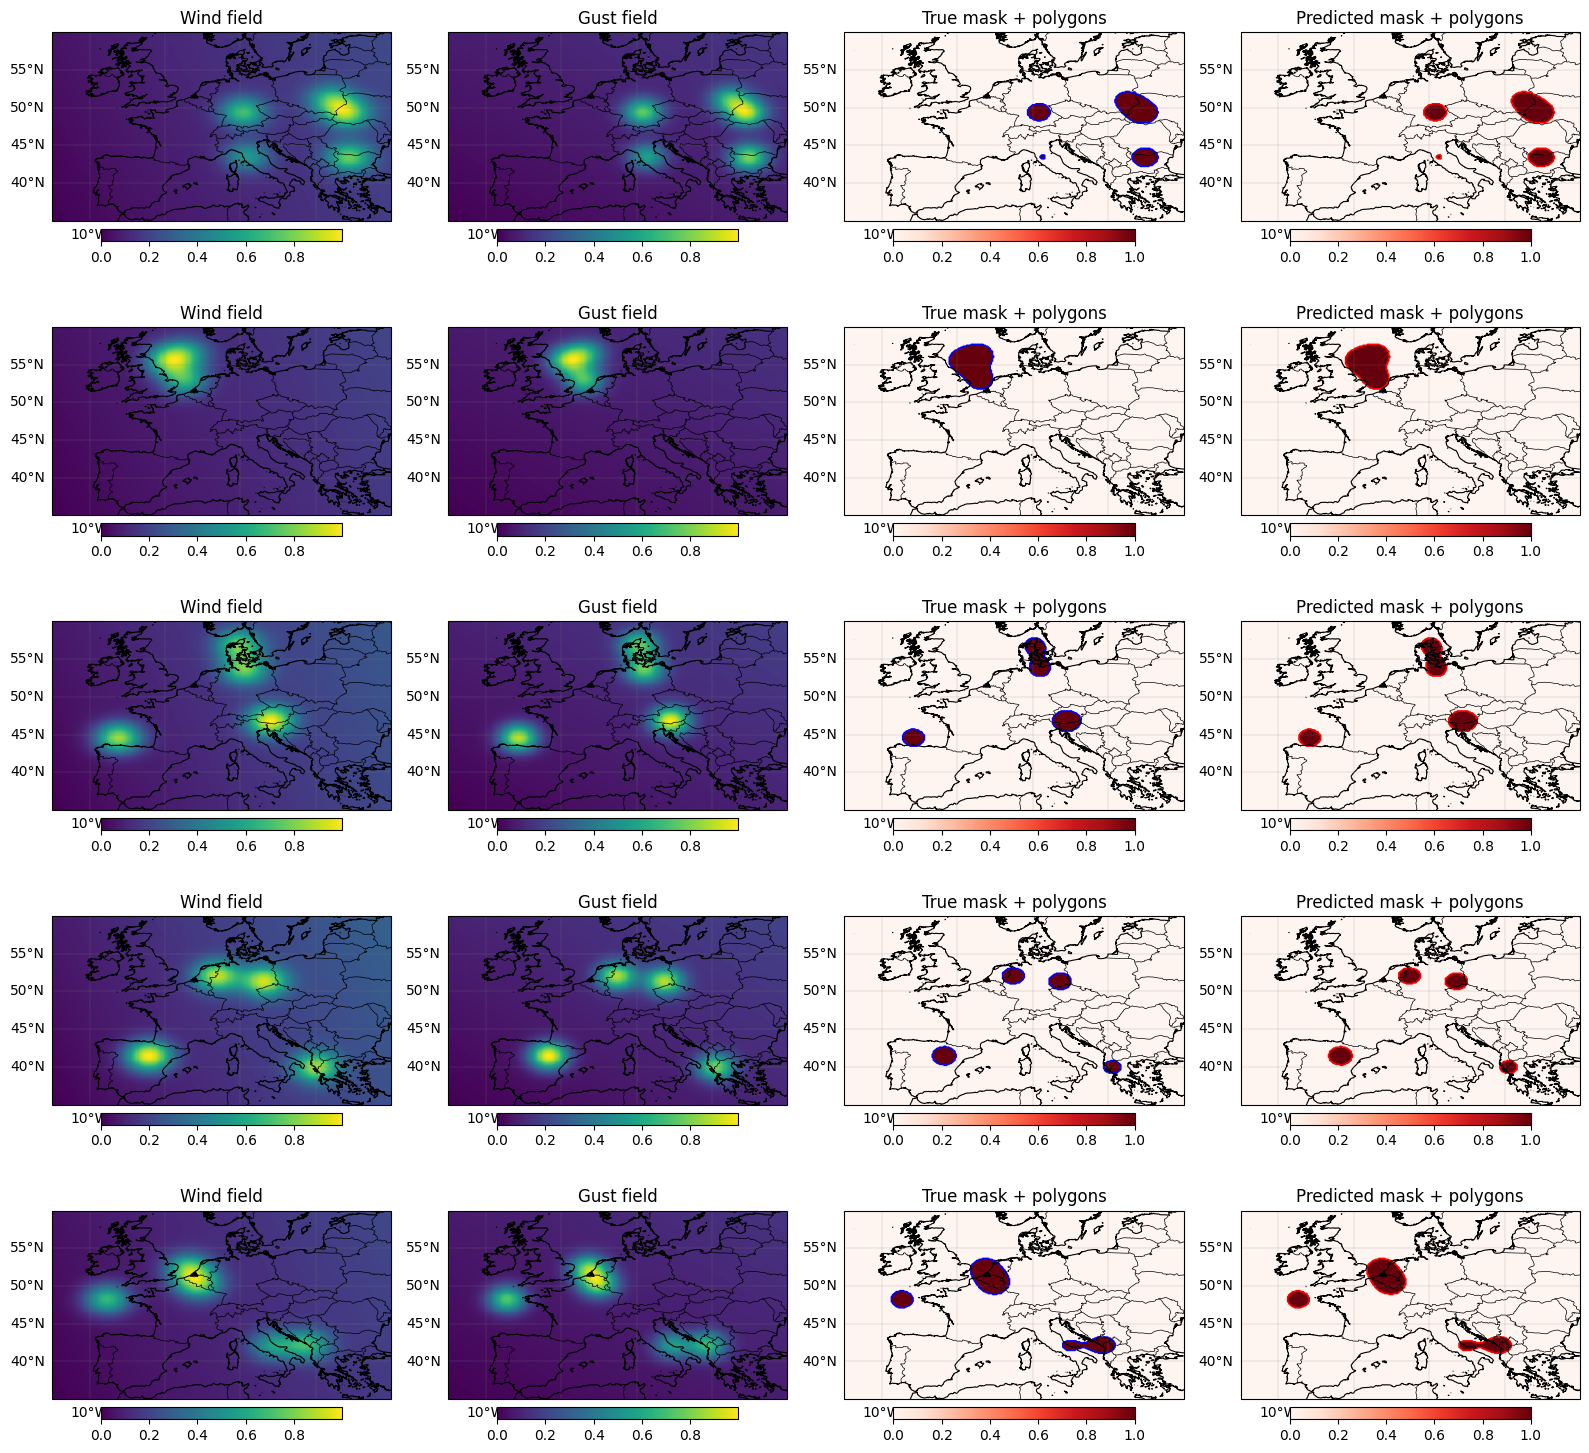

In [9]:
# --- STEP D: Evaluate and visualize Ntest samples (4 columns per sample) ---

import numpy as np
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path

# ---------- Parameters ----------
DATADIR = Path("warn_demo/samples")
MODEL_PATH = DATADIR / "global_field_mlp.pt"
Ntest = 5  # number of test samples to visualize

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- Helper functions ----------
def load_field_pairs(datadir):
    X_list, Y_list, lonlat = [], [], None
    for f in sorted(datadir.glob("sample_*.npz")):
        d = np.load(f)
        w, g, m = d["wind"], d["gust"], d["mask"]
        lon, lat = d["lon"], d["lat"]
        w = (w - w.min()) / (w.max() - w.min() + 1e-8)
        g = (g - g.min()) / (g.max() - g.min() + 1e-8)
        X_list.append(np.stack([w, g], axis=0))
        Y_list.append(m)
        lonlat = (lon, lat)
    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    return X, Y, lonlat

def mask_to_polygons(mask, lon2d, lat2d, level=0.5, min_vertices=6):
    fig, ax = plt.subplots()
    cs = ax.contour(lon2d, lat2d, mask, levels=[level])
    polygons = []
    if hasattr(cs, "collections"):
        for coll in cs.collections:
            for path in coll.get_paths():
                v = path.vertices
                if v.shape[0] >= min_vertices:
                    polygons.append([(float(x), float(y)) for x, y in v])
    elif hasattr(cs, "get_paths"):
        for path in cs.get_paths():
            v = path.vertices
            if v.shape[0] >= min_vertices:
                polygons.append([(float(x), float(y)) for x, y in v])
    plt.close(fig)
    return polygons

def setup_map(ax, extent):
    proj = ccrs.PlateCarree()
    ax.set_extent(extent, crs=proj)
    ax.coastlines("10m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)
    gl.top_labels = gl.right_labels = False

def draw_polygons(ax, polygons, color="blue", linewidth=1.2):
    proj = ccrs.PlateCarree()
    for poly in polygons:
        verts = np.asarray(poly)
        if len(verts) < 3:
            continue
        # split disconnected segments
        d = np.sqrt(np.sum(np.diff(verts, axis=0)**2, axis=1))
        breaks = np.where(d > 2.0)[0]
        segs, start = [], 0
        for b in breaks:
            segs.append(verts[start:b+1])
            start = b+1
        segs.append(verts[start:])
        for seg in segs:
            if len(seg) < 3:
                continue
            if not np.allclose(seg[0], seg[-1]):
                seg = np.vstack([seg, seg[:1]])
            codes = np.full(len(seg), MplPath.LINETO, dtype=np.uint8)
            codes[0] = MplPath.MOVETO
            codes[-1] = MplPath.CLOSEPOLY
            path = MplPath(seg, codes)
            patch = PathPatch(path, transform=proj, fill=False, edgecolor=color, linewidth=linewidth)
            ax.add_patch(patch)

# ---------- Load dataset ----------
X, Y, (lon, lat) = load_field_pairs(DATADIR)
ntrain, _, n1, n2 = X.shape
lon2d, lat2d = np.meshgrid(lon, lat)
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# ---------- Model ----------
class GlobalFieldMLP(torch.nn.Module):
    def __init__(self, n1, n2, hidden=1024):
        super().__init__()
        nin = 2 * n1 * n2
        nout = n1 * n2
        self.net = torch.nn.Sequential(
            torch.nn.Linear(nin, hidden), torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden), torch.nn.ReLU(),
            torch.nn.Linear(hidden, nout), torch.nn.Sigmoid()
        )
        self.n1, self.n2 = n1, n2
    def forward(self, x):
        out = self.net(x)
        return out.view(-1, self.n1, self.n2)

model = GlobalFieldMLP(n1, n2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ---------- Run predictions ----------
Xf = X.reshape(ntrain, -1)
with torch.no_grad():
    pred = model(torch.tensor(Xf, dtype=torch.float32)).numpy()
mask_pred = (pred > 0.5).astype(np.uint8)

# ---------- Visualize Ntest rows ----------
Ntest = min(Ntest, ntrain)
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(Ntest, 4, figsize=(16, 3*Ntest), subplot_kw={"projection": proj})

if Ntest == 1:
    axes = axes[np.newaxis, :]  # ensure 2D indexable

for i in range(Ntest):
    w = X[i, 0]
    g = X[i, 1]
    m_true = Y[i]
    m_pred = mask_pred[i]
    poly_true = mask_to_polygons(m_true, lon2d, lat2d)
    poly_pred = mask_to_polygons(m_pred, lon2d, lat2d)

    titles = ["Wind field", "Gust field", "True mask + polygons", "Predicted mask + polygons"]
    data = [w, g, m_true, m_pred]
    cmaps = ["viridis", "viridis", "Reds", "Reds"]
    polysets = [None, None, poly_true, poly_pred]

    for j in range(4):
        ax = axes[i, j]
        setup_map(ax, extent)
        im = ax.pcolormesh(lon, lat, data[j], transform=proj, cmap=cmaps[j], vmin=0, vmax=data[j].max())
        if polysets[j]:
            draw_polygons(ax, polysets[j], color="blue" if j == 2 else "red")
        ax.set_title(titles[j])
        fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.03, fraction=0.045)

plt.tight_layout()
plt.savefig("polygon_prediction_test2.png")
plt.show()
